# Passer Ratings: Physical attributes 🤙 💪 🧍

Hypothesis: Hand size/height/arm length affects average career passer rating.

In [58]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
import pickle
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# import pymc3 as pm
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
df = pd.read_csv('../data/passer_ratings.csv', index_col=0)
df['attempts'] = round(df['attempts']/100)
df['sack_rate'] = round(df['sack_rate']*100,2)
df['alt_rate'] = round(df['alt_rate']*100,2)
df['precip_rate'] = round(df['precip_rate']*100,2)
df['turf_rate'] = round(df['turf_rate']*100,2)
df['away_rate'] = round(df['away_rate']*100,2)
df['temp'] = round(df['temp'])
df.drop(['alt_rate', 'wind_rate'], axis=1, inplace=True)
df

,year,attempts,avg_rating,sack_rate,precip_rate,turf_rate,away_rate,temp,height,arm,hand,dpos,seasons
DB-3800-2011,2011,8.0,110.6,3.65,0.00,72.22,50.00,69.0,72.0,31.250,10.00,32,11
PM-0200-2013,2013,8.0,111.7,2.23,5.26,26.32,42.11,58.0,77.0,31.500,10.13,1,16
EM-0200-2011,2011,8.0,95.1,4.93,10.00,75.00,55.00,58.0,77.0,30.750,9.75,1,8
TB-2300-2011,2011,7.0,104.8,4.62,0.00,63.16,42.11,55.0,76.0,32.750,9.38,199,12
MR-2500-2016,2016,6.0,119.9,6.61,5.26,73.68,42.11,69.0,77.0,32.375,9.50,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TD-1400-2007,2007,2.0,55.1,10.93,0.00,14.29,42.86,60.0,76.0,32.250,9.63,6,14
MM-2800-2005,2005,2.0,55.2,8.41,11.11,22.22,33.33,56.0,74.0,32.000,9.75,149,5
JS-3700-2012,2012,2.0,55.4,6.94,14.29,57.14,57.14,64.0,77.0,32.000,9.75,285,3
SM-2400-2007,2007,2.0,73.9,4.63,16.67,16.67,66.67,66.0,74.0,32.250,10.50,3,13


## Variable of Interest

First we dichotamise the variable of interest. For example, we may filter to only include big or small handed players. We say small hand QB's are those in the bottom 1/3rd, and large hands are the top 1/3rd.

Height and arm length are postively correlated (0.45), so it's a little difficult to control for one when investigating the other. Height is of bigger interest than arm, and we suspect it is a bigger influence. However we see the drawback in not controlling for this. 

In [60]:
df_exp = df.copy()

In [61]:
on = 'big_hands' # the name of the dichotomous variable
original = 'hand' # the original variable name
drop = []

# specifically for height study
# df_exp.drop('arm', axis=1, inplace=True)

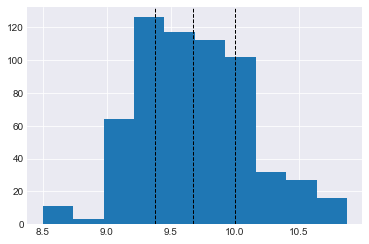

In [62]:
df_exp[original].hist()
plt.axvline(df_exp[original].mean(), color='k', linestyle='dashed', linewidth=1)

big = np.percentile(df_exp[original], q=75)
small = np.percentile(df_exp[original], q=25)
plt.axvline(big, color='k', linestyle='dashed', linewidth=1)
plt.axvline(small, color='k', linestyle='dashed', linewidth=1)

In [63]:
df_exp = df_exp.loc[(df_exp[original]>=big) | (df_exp[original]<=small), :] # only extreme values
df_exp[on] = df_exp[original]>=big
df_exp = df_exp.drop(original, axis=1)
print(big, small)
df_exp[on].value_counts()

10.0 9.375


False    183
True     177
Name: big_hands, dtype: int64

In [64]:
df_exp

,year,attempts,avg_rating,sack_rate,precip_rate,turf_rate,away_rate,temp,height,arm,dpos,seasons,big_hands
DB-3800-2011,2011,8.0,110.6,3.65,0.00,72.22,50.00,69.0,72.0,31.250,32,11,True
PM-0200-2013,2013,8.0,111.7,2.23,5.26,26.32,42.11,58.0,77.0,31.500,1,16,True
DB-3800-2013,2013,7.0,102.3,5.24,11.11,77.78,55.56,63.0,72.0,31.250,32,13,True
PM-0025-2018,2018,7.0,112.2,4.80,0.00,11.11,44.44,54.0,74.0,33.250,10,2,False
AL-1100-2014,2014,7.0,92.5,3.66,5.26,63.16,52.63,61.0,76.0,32.625,1,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM-0900-2002,2002,2.0,72.6,3.66,28.57,14.29,57.14,64.0,75.0,31.630,285,7,False
KC-2000-2009,2009,2.0,65.5,2.24,42.86,28.57,57.14,63.0,77.0,32.750,1,15,True
MB-4500-2004,2004,2.0,63.9,5.93,0.00,22.22,44.44,64.0,73.0,32.250,118,12,False
SM-2400-2007,2007,2.0,73.9,4.63,16.67,16.67,66.67,66.0,74.0,32.250,3,13,True


## Matching

### Coarsened Exact Matching

In [11]:
from util.matching import CEM

In [21]:
bins = {
    'year': range(3,5),
    'attempts': range(3,5),
    'sack_rate': range(2,5),
    'precip_rate': [2],
    'turf_rate': [2],
    'away_rate': [2],
    'temp': range(2,5),
    'height': [2],
    'arm': [2],
    'hand': range(2,4),
    'dpos': range(2,4),
    'temp': range(2,4),
    'seasons': range(3,5),
    on: [2], # treatment
}
bins.pop(original)
bins

{'year': range(3, 5),
 'attempts': range(3, 5),
 'sack_rate': range(2, 5),
 'precip_rate': [2],
 'turf_rate': [2],
 'wind_rate': [2],
 'away_rate': [2],
 'height': [2],
 'arm': [2],
 'hand': [2],
 'dpos': [2],
 'seasons': range(3, 5),
 'warm': [2]}

In [ ]:
L1_results = CEM(df_exp, treatment=on, outcome='avg_rating').relax(bins)
L1_results

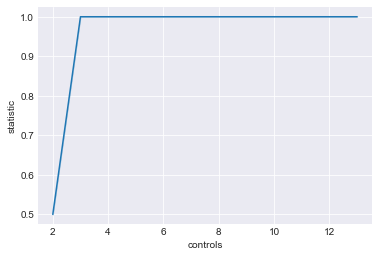

In [9]:
sns.lineplot(x='controls', y='statistic', data=L1_results)

In [65]:
bins = {
    'year': 3,
    'attempts': 2,
    'sack_rate': 2,
    'precip_rate': 2,
    'turf_rate': 2,
    'away_rate': 2,
    'temp': 2,
    'height': 2,
    'arm': 2,
    'hand': 2,
    'dpos': 2,
    'temp': 2,
    'seasons': 2
}
bins.pop(original)
bins

{'year': 3,
 'attempts': 2,
 'sack_rate': 2,
 'precip_rate': 2,
 'turf_rate': 2,
 'away_rate': 2,
 'temp': 2,
 'height': 2,
 'arm': 2,
 'dpos': 2,
 'seasons': 2}

In [66]:
cem = CEM(df_exp, treatment=on, outcome='avg_rating')
cem.match(bins=bins)
print('L1:', cem.score())
cem.data.loc[cem.weights>0, on].value_counts()
# we do not have enough pairs to use regression

L1: 0.4999999999999997


False    42
True     29
Name: big_hands, dtype: int64

In [11]:
summary = cem.regress(drop=drop)
summary

C:\Users\Lewis.Bails\AppData\Local\Continuum\anaconda3\envs\conda_pymc3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Lewis.Bails\AppData\Local\Continuum\anaconda3\envs\conda_pymc3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             avg_rating   No. Observations:                  141
Model:                            GLM   Df Residuals:                      128
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          bfgs   Log-Likelihood:                    nan
Date:                Sun, 29 Mar 2020   Deviance:                   9.3211e+05
Time:                        10:21:09   Pearson chi2:                 4.29e+21
No. Iterations:                     0                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -5.748e+18        nan        nan        nan         nan         nan
warm[T.True]  1.254e+16        nan        nan        nan         nan         nan
year          3.143e+15        nan        nan        nan         nan         nan
attempts      1.103e+16        nan        nan        nan         nan         nan
sack_rate    -8.385e+14        nan        nan        nan         nan         nan
precip_rate  -4.076e+14        nan        nan        nan         nan         nan
turf_rate     2.334e+14        nan        nan        nan         nan         nan
away_rate    -1.078e+15        nan        nan        nan         nan         nan
height        5.435e+15        nan        nan        nan         nan         nan
arm          -1.636e+16        nan        nan        nan         nan         nan
hand          8.113e+15        nan        nan        nan         nan         nan
dpos         -8.147e+13        nan        nan        nan         nan         nan
seasons       3.244e+15        nan        nan        nan         nan         nan
================================================================================
"""

In [ ]:
from util.matching import summary_to_frame
results = pd.concat([summary_to_frame(s['summary'],s['n_bins'],s['vc'], dtype=float) for s in summary.values()]).dropna()
results = results.loc[results['P>|z|']<=0.1, :]
results

In [ ]:
sns.lineplot(x='n_bins', y='coef', data=results.loc[results['covariate']!='Intercept', :], hue='covariate')

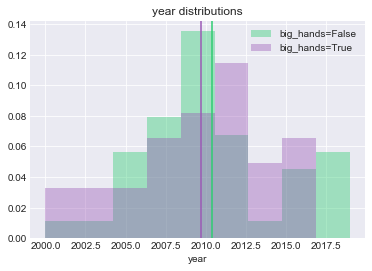

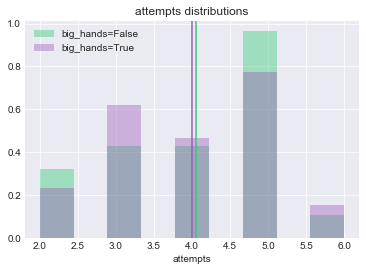

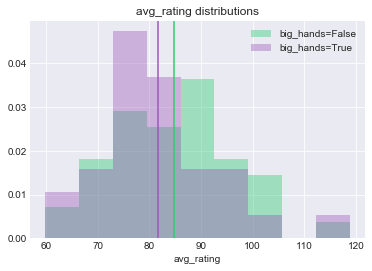

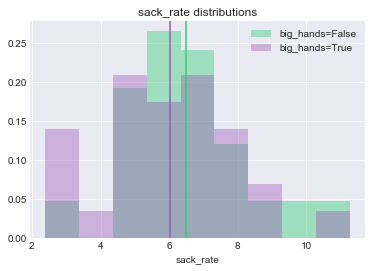

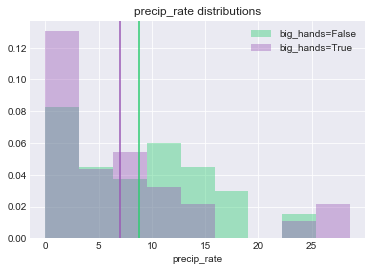

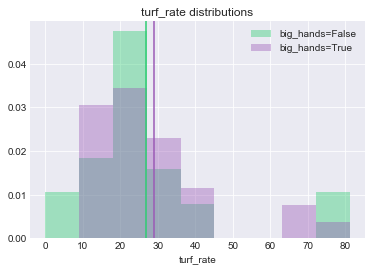

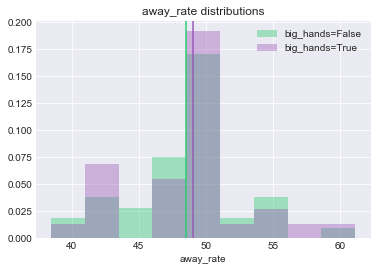

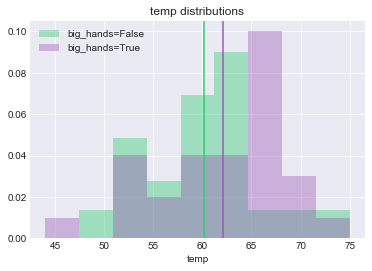

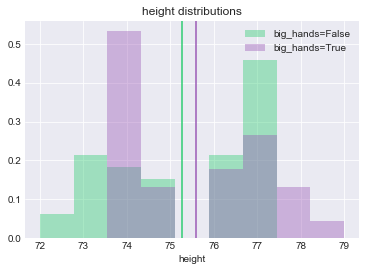

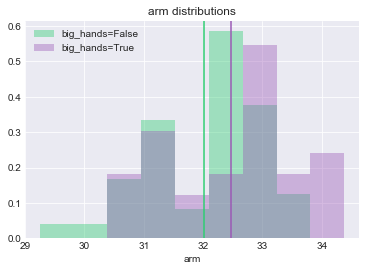

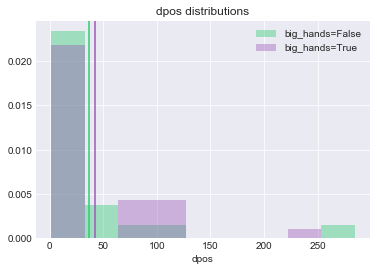

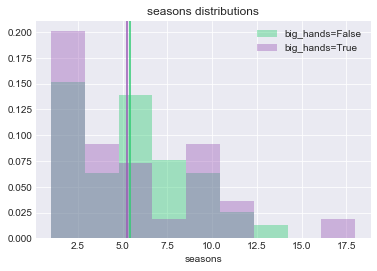

In [68]:
from util.matching import covariate_dists
covariate_dists(cem.data.loc[cem.weights>0, :], on=on, kde=False, hist=True, n_bins=10)

### Weighted Difference of Means

In [67]:
cem.LSATT()

(OrderedDict([(False, [82.06724137931035, 12.264888480701874, 42]),
              (True, [81.60000000000002, 11.59509408743852, 29])]),
 Ttest_indResult(statistic=0.1629921188324602, pvalue=0.8710505168929471))

### Mahalanobis Matching

We can calculate the mahalanobis frontier to see how the aggregate mahalanobis distance is changing with radius.

In [ ]:
from util.matching import mahalanobis_frontier, match_by_distance
df_exp[on] = df_exp[on].astype(bool)
df_mf = mahalanobis_frontier(df_exp.drop('avg_rating', axis=1), on)
df_mf

In [ ]:
sns.lineplot(x='pruned controls', y='AMD', data=df_mf)
plt.title('Mahalanobis Matching Frontier')
plt.show()
plt.title('Mahalanobis Matching Frontier')
sns.lineplot(x='pruned treatments', y='AMD', data=df_mf)
plt.show()
plt.title('Mahalanobis Matching Frontier')
sns.lineplot(x='radius', y='AMD', data=df_mf)

We choose a reasonable radius/caliper to minimise difference in marginal distributions but also keep as many controls as possible. This is a little difficult because we're not working with very large sample sizes as it is.

In [ ]:
df_matched = match_by_distance(df_exp, on, 'avg_rating', 'mahalanobis', caliper=2)

In [ ]:
from util.matching import covariate_dists
covariate_dists(df_matched.drop('avg_rating', axis=1), on=on, kde=False, hist=True, n_bins=10)

We can perform a t-test for difference of sample means. We're more interested in distribution similarity, but large difference of means can indicate problems. The p value is the probability of observing such a difference between sample means given their population means are equal.

In [ ]:
from scipy.stats import ttest_ind

for col in df_matched.drop(['avg_rating', on], axis=1).columns:
    rvs1 = df_matched.loc[df_matched[on], col]
    rvs2 = df_matched.loc[~df_matched[on], col]
    _, p = ttest_ind(rvs1, rvs2, equal_var = False)
    print(f'P(x|H0) for {col}: {round(p,2)}')

In [ ]:
df_treatment = df_matched.loc[df_matched[on],:]
df_control = df_matched.loc[~df_matched[on], :]
print(len(df_treatment), f'{on} samples.', len(df_control), f'not {on} samples.')

## Model -- If you want to use BEST you'll need to find a way to included weights or use a 1:1 exact matching

We'll use the BEST method for comparing means of the two groups.

In [78]:
dd = pd.concat((cem.data, cem.weights.rename('weights')), axis=1)
dd = dd.loc[dd['weights']>0, :]
treatment = dd.loc[dd[on], 'avg_rating']
control = dd.loc[~dd[on], 'avg_rating']
weights = dd['weights']

In [ ]:
f, axes = plt.subplots(1,2, sharey=True, sharex=True)
sns.distplot(treatment, ax=axes[0])
axes[0].set_title(f'Passer rating - {on}')
sns.distplot(control, ax=axes[1])
axes[1].set_title(f'Passer rating - not {on}')
plt.show()

Because of the relatively small sample sizes we assume our distributions are of the students-t distribution (Kruschke).
The students-t has a mean, variance, and degree-of-freedom.
The degree of freedom control the normality of the data (larger dof converges to normal distribution).

Lets set up the model

In [ ]:
# priors on the mean
m_mu = pd.concat([control,treatment]).mean()
m_sd = pd.concat([control,treatment]).std()

with pm.Model() as model:
    treatment_mean = pm.Normal('treatment_mean', mu=m_mu, sd=m_sd)
    control_mean = pm.Normal('control_mean', mu=m_mu, sd=m_sd)

In [ ]:
# priors on the standard deviation
sd_low = 1
sd_high = 30

with model:
    treatment_std = pm.Uniform('treatment_std', lower=sd_low, upper=sd_high)
    control_std = pm.Uniform('control_std', lower=sd_low, upper=sd_high)

In [ ]:
# shared prior on the degree of freedom parameter
with model:
    v = pm.Exponential('v_minus_one', 1/29.) + 1

In [ ]:
# pymc3 paramaterises students t with precision, rather than standard deviation (lambda = 1/sigma^2)
with model:
    treatment_lambda = treatment_std**-2  # deterministic
    control_lambda = control_std**-2 # deterministic

    treatment_rating = pm.StudentT(f'{on}', nu=v, mu=treatment_mean, lam=treatment_lambda, observed=treatment)
    control_rating = pm.StudentT(f'not {on}', nu=v, mu=control_mean, lam=control_lambda, observed=control)

In [ ]:
with model:
    # our deterministic values, we could just have easily done this with the traces.
    diff_of_means = pm.Deterministic('difference_of_means', treatment_mean - control_mean)
    diff_of_stds = pm.Deterministic('difference_of_stds', treatment_std - control_std)
    effect_size = pm.Deterministic('effect_size',
                                   diff_of_means / np.sqrt((treatment_std**2 + control_std**2) / 2)) # hard to interpret but is difference scaled by pooled variance

In [ ]:
with model:
    trace = pm.sample(2000) # NUTS sampling for filling our posterior

    # dump the trace
    today = dt.now().strftime('%y%m%d')
    with open(f'../results/trace_{on}_{today}.pckle', 'wb') as f:
        pickle.dump(trace, f)

In [ ]:
pm.plot_posterior(trace)

In [ ]:
pm.plot_posterior(trace, var_names=['difference_of_means','difference_of_stds', 'effect_size'],
                  ref_val=0,
                  color='#87ceeb')

In [ ]:
# the diagnostics show that the sampling went as suspected with no issues (Rhat ~ 1)
from util.stats import summary
summary_ = summary(trace)
summary_ # error out

## TODO: Relative difference in means/lift.